# Soil & Landform micro-service (2020-10-14)


In [1]:
from owslib.wps import WebProcessingService

wps = WebProcessingService('https://api.soillandform.bccvl.org.au/wps', verbose=False, skip_caps=True)
wps.getcapabilities()
wps.identification.type

'WPS'

In [2]:
wps.identification.title

'PyWPS Processing Service'

In [3]:
wps.identification.abstract

'PyWPS is an implementation of the Web Processing Service standard from the Open Geospatial Consortium. PyWPS is written in Python.'

In [4]:
for operation in wps.operations:
    print(operation.name)

GetCapabilities
DescribeProcess
Execute


## What processes are supported?

In [5]:
for process in wps.processes:
    print("{:>30}: {}".format(process.identifier, process.title))

               one_wps_process: Soil & Land form (soillandform) combined process for spatial and multiple-variable selections.


## Getting Process Descriptions

In [6]:
from owslib.wps import printInputOutput

process = wps.describeprocess('one_wps_process')
process.identifier

'one_wps_process'

In [7]:
process.title

'Soil & Land form (soillandform) combined process for spatial and multiple-variable selections.'

In [8]:
process.abstract

"Single entry point for all of soil & land form's functions."

In [9]:
for input in process.dataInputs:
    printInputOutput(input)
    print()

 identifier=spatial_selection_type, title=Type of selection in space, abstract=None, data type=string
 Allowed Value: rectangular_region
 Allowed Value: single_location
 Allowed Value: predefined_region
 Allowed Value: polygon
 Default Value: None 
 minOccurs=1, maxOccurs=1

 identifier=variables, title=variables to extract, abstract=None, data type=string
 Default Value: None 
 minOccurs=1, maxOccurs=1

 identifier=lat, title=Latitude value to process in range -43.735:-9.005, abstract=None, data type=float
 Default Value: None 
 minOccurs=0, maxOccurs=1

 identifier=lat_min, title=Latitude value to process from, in range -43.735:-9.005, abstract=None, data type=float
 Default Value: None 
 minOccurs=0, maxOccurs=1

 identifier=lat_max, title=Latitude value to process to, in range -43.735:-9.005, abstract=None, data type=float
 Default Value: None 
 minOccurs=0, maxOccurs=1

 identifier=lon, title=Longitude value to process in range 112.905:153.995, abstract=None, data type=float
 Defa

In [10]:
for output in process.processOutputs:
    printInputOutput(output)

 identifier=output, title=Metadata, abstract=None, data type=ComplexData
 Supported Value: mimeType=application/zip, encoding=None, schema=None
 Default Value: mimeType=application/zip, encoding=None, schema=None 
 reference=None, mimeType=None


## Understanding the Unified WPS API

Soil & Landform micro-service access is through one WPS API process. 
It is identified by the processid `one_wps_process`.

You need to specify a list of `variables` to select from the dataset. To know which variables are available for selection, we need to query the micro-service. We will perform this step soon.

We have 4 types of spatial selections. 
Each have related parameters that must be specified.

To specify a spatial selection, you use the parameter `spatial_selection_type`. The options are: 

- `rectangular_region`, 
- `predefined_region`, 
- `single_location`, 
- `polygon`.

When you select a spatial selection, there are additional parameters that nneed to be specified:

|Spatial Selection Type|Associated Parameters|
|-----------------|--------------------|
|rectangular_region|lat_min, lat_max, lon_min, lon_max|
|single_location|lat, lon|
|predefined_region|gdb_name, rec_id|
|polygon|geometry|

If you choose the `single_location`, for example, then you need to specify the variables `lat` and `lon`, as shown above.

This dataset does not have a `time` dimension, so there is no need to specify a time variable.


## Monitoring the Execution

Before we submit a process for execution, lets define a function to allow us to monitor the execution.

In [11]:
def monitor_execution(execution, sleepSecs=5, download=False, filepath='data/out.zip'):
    while execution.isComplete() is False:
        execution.checkStatus(sleepSecs=sleepSecs)
        print(f'Execution status: {execution.statusMessage}')

    if execution.isSucceded():
        if download:
            execution.getOutput(filepath=filepath)
        else:
            for output in execution.processOutputs:
                if output.reference is not None:
                    print('Output URL={}'.format(output.reference))
    else:
        for ex in execution.errors:
            print('Error: code={}, locator={}, text={}'.format(ex.code, ex.locator, ex.text))

The parameters are the following:

- `execution`: the wps process we submitted
- `sleepSecs`: how often to report the status (in seconds)
- `download`: if we want to download the result, then use filepath; otherwise, report a URL.
- `filepath`: path to where we want to store the result

If the execution terminated with errors, they will be listed.

## Request a list of Variables

Since the Soil and Landform micro-service uses 18 variables, 
we need to get a list of the variables supported.

In [12]:
import requests
import json

response = requests.get("https://api.soillandform.bccvl.org.au/variables")
data = response.json()
print(json.dumps(data, indent=4))


{
    "data": {
        "variables": {
            "by_index": {
                "awc": "Available Water Capacity",
                "bdw": "Bulk Density - Whole Earth",
                "cly": "Clay",
                "der": "Depth of Regolith",
                "des": "Depth of Soil",
                "ece": "Effective Cation Exchange Capacity",
                "nto": "Total Nitrogen",
                "phc": "pH - CaCl2",
                "pto": "Total Phosphorus",
                "slt": "Silt",
                "snd": "Sand",
                "soc": "Organic Carbon",
                "twi": "Topographic wetness index",
                "slopedeg": "Slope",
                "profcurv": "Profile curvature",
                "plancurv": "Plan curvature",
                "elvr1000": "Elevation",
                "conarea": "Contributing area"
            }
        }
    },
    "metadata": {
        "service": "Soil & Landform (soillandform) microservice",
        "publisher": "ecoCommons Australia",

## Execute a Rectangular Region Selection

Now we are ready to submit a request. Lets say that we want to extract a rectangular region of South-East Queensland. The request will like like this:

In [13]:
processid = 'one_wps_process'
inputs = [
    ("variables", "awc, bdw, cly"), 
    ("spatial_selection_type", "rectangular_region"),
    ("lat_min", "-28.17702"), ("lat_max", "-26.33033"),
    ("lon_min", "152.81753281"), ("lon_max", "153.55292")
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

'ProcessAccepted'

In [14]:
monitor_execution(execution, sleepSecs=10, download=True, filepath='data/outputs/out20201014T1450.zip')

Execution status: PyWPS Process started
Execution status: rectangular_region select 4/6 (66%)
Execution status: PyWPS Process Soil & Land form (soillandform) combined process for spatial and multiple-variable selections. finished


### Zip Results

In [15]:
filepath='data/outputs/out20201014T1450.zip'

The result comes in a zip file. Lets examine the contents:

In [16]:
from zipfile import ZipFile

f = ZipFile(filepath)
print(f.namelist())
f.close()

['awc.tif', 'result.zarr', 'bdw.tif', 'metadata.json', 'awc.csv', 'bdw.csv', 'cly.csv', 'result.csv', 'cly.tif', 'result.nc']


### Metadata

In [17]:
import json

with ZipFile(filepath) as z:
    with z.open('metadata.json') as zf:
        data = json.load(zf)
        print(json.dumps(data, indent=4))

{
    "variables": {
        "codes": [
            "awc",
            "bdw",
            "cly"
        ],
        "selected": {
            "awc": "Available Water Capacity",
            "bdw": "Bulk Density - Whole Earth",
            "cly": "Clay"
        }
    },
    "spatial_selection_type": "rectangular_region",
    "bounds": {
        "lat_min": -28.175,
        "lat_max": -26.335,
        "lon_min": 152.815,
        "lon_max": 153.555
    }
}


### Process the NetCDF File

Lets extract the result.nc (NetCDF) file, open it as an xarray dataset, and examine its contents.

In [19]:
import xarray as xr

with ZipFile(filepath) as z:
    res = z.extract('result.nc', path='workspace/data/outputs/')
    xds = xr.load_dataset(res)
xds

<xarray.Dataset>
Dimensions:  (lat: 732, lon: 296)
Coordinates:
  * lat      (lat) float64 -28.17 -28.17 -28.17 -28.17 ... -26.34 -26.34 -26.34
  * lon      (lon) float64 152.8 152.8 152.8 152.8 ... 153.5 153.5 153.6 153.6
Data variables:
    awc      (lat, lon) float32 14.734 14.6586 14.3163 ... -3.4e+38 -3.4e+38
    bdw      (lat, lon) float32 1.4004 1.3883 1.3785 ... -3.4e+38 -3.4e+38
    cly      (lat, lon) float32 29.1332 28.0801 27.969 ... -3.4e+38 -3.4e+38
Attributes:
    geospatial_lat_min:         -28.174
    geospatial_lat_max:         -26.336
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_min:         152.816
    geospatial_lon_max:         153.554
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    DOI:                        to be added
    license_data_access:        These data can be freely downloaded and used
    keywords:                   EARTH SCIENCE > ENVIRONMENT
    summary:  

Notice the result is a cube, with 2 coordinates: `lat`, `lon`.
    
- `lat`: gives us the latitude range (an array of floats)
- `lon`: gives us the longitude range (an array of floats)

The cube's data values are under `Data Values`, in their respective sections under their names.

There are also some metadata `Attributes` to inform us of various things: license, publisher, etc

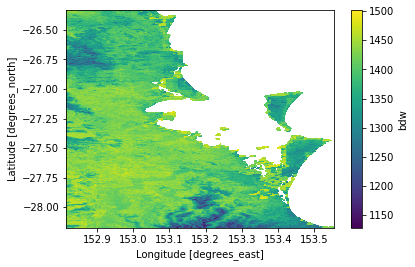

In [21]:
from matplotlib import pyplot as plt

(xds['bdw'] * 1000).plot()

The map shows a section of South-East Queensland, between Sunshine Coast and Gold Coast, with Brisbane in the middle.
For the plot, the numbers have been 'amplified' by a factor of 1000.

### Tiff Results

In [22]:
import rasterio as rio

with ZipFile(filepath) as z:
    tf = z.extract('cly.tif', path='data/outputs')
    rds = rio.open(tf)
        
data = {  # gather all the attrs together
    'meta': rds.meta,
    'bounds': rds.bounds,
    'resolution': rds.res,
    'tags': rds.tags, 
    'indexes': rds.indexes,
    'name': rds.name, 
    'mode': rds.mode
}
data  # notice count: 1, means 1 layer

{'meta': {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': None,
  'width': 296,
  'height': 732,
  'count': 1,
  'crs': CRS.from_dict(init='epsg:4326'),
  'transform': Affine(0.0025000000000000386, 0.0, 152.815,
         0.0, 0.0025136798905608785, -28.175006839945283)},
 'bounds': BoundingBox(left=152.815, bottom=-26.33499316005472, right=153.555, top=-28.175006839945283),
 'resolution': (0.0025000000000000386, -0.0025136798905608785),
 'tags': <function DatasetReader.tags>,
 'indexes': (1,),
 'name': 'data/outputs/cly.tif',
 'mode': 'r'}

In [23]:
rds.read(1)

array([[ 2.91332e+01,  2.80801e+01,  2.79690e+01, ...,  3.72748e+01,
         3.75451e+01,  3.75451e+01],
       [ 2.81137e+01,  2.93342e+01,  2.82219e+01, ...,  3.75451e+01,
         3.75451e+01, -3.40000e+38],
       [ 2.76644e+01,  2.95829e+01,  2.85419e+01, ...,  3.36361e+01,
         3.75451e+01, -3.40000e+38],
       ...,
       [ 3.47250e+01,  3.76316e+01,  3.65505e+01, ..., -3.40000e+38,
        -3.40000e+38, -3.40000e+38],
       [ 3.31855e+01,  3.49635e+01,  3.43350e+01, ..., -3.40000e+38,
        -3.40000e+38, -3.40000e+38],
       [ 3.24228e+01,  3.50335e+01,  3.62461e+01, ..., -3.40000e+38,
        -3.40000e+38, -3.40000e+38]], dtype=float32)

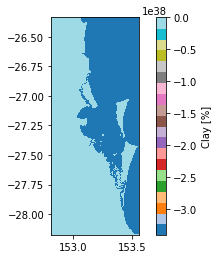

In [24]:
from matplotlib import pyplot as plt

axs = plt.imshow(rds.read(1), cmap='tab20', origin='lower',
                 extent=(rds.bounds.left, rds.bounds.right, rds.bounds.top, rds.bounds.bottom))
plt.colorbar(label='Clay [%]')
plt.show()

### Processing the CSV File

In [25]:
import pandas as pd

with ZipFile(filepath) as z:
    with z.open('result.csv') as zf:
        df = pd.read_csv(zf)
df.head()

,lat,lon,awc,bdw,cly
0,-28.17375,152.81625,14.7340,1.4004,29.1332
1,-28.17375,152.81875,14.6586,1.3883,28.0801
2,-28.17375,152.82125,14.3163,1.3785,27.9690
3,-28.17375,152.82375,14.1650,1.3648,27.2269
4,-28.17375,152.82625,13.7893,1.3645,28.0176


## Single Location Region Selections

In [26]:
processid = 'one_wps_process'
inputs = [
    ("variables", "der, des, ece"), 
    ("spatial_selection_type", "single_location"),
    ("lat", "-27.784490"), ("lon", "153.261301")
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

'ProcessAccepted'

In [27]:
monitor_execution(execution, sleepSecs=10, download=True, filepath='data/outputs/out20201014T1510.zip')

Execution status: PyWPS Process started
Execution status: PyWPS Process Soil & Land form (soillandform) combined process for spatial and multiple-variable selections. finished


In [28]:
filepath='data/outputs/out20201014T1510.zip'

### Zip Results

In [29]:
from zipfile import ZipFile

with ZipFile(filepath) as f:
    print(f.namelist())

['metadata.json', 'result.csv', 'result.nc']


### Metadata

In [30]:
import json

with ZipFile(filepath) as z:
    with z.open('metadata.json') as zf:
        data = json.load(zf)
        print(json.dumps(data, indent=4))

{
    "variables": {
        "codes": [
            "der",
            "des",
            "ece"
        ],
        "selected": {
            "der": "Depth of Regolith",
            "des": "Depth of Soil",
            "ece": "Effective Cation Exchange Capacity"
        }
    },
    "spatial_selection_type": "single_location",
    "coords": {
        "lat": -27.785,
        "lon": 153.265
    }
}


### NetCDF Results

In [31]:
import xarray as xr

with ZipFile(filepath) as z:
    res = z.extract('result.nc', path='workspace/data/outputs/')
    xds = xr.load_dataset(res)
xds

<xarray.Dataset>
Dimensions:   (measures: 3)
Coordinates:
  * measures  (measures) object 'der' 'des' 'ece'
    lat       float64 -27.78
    lon       float64 153.3
Data variables:
    der       (measures) float32 6.1803 nan nan
    des       (measures) float32 nan 1.1515 nan
    ece       (measures) float32 nan nan 9.741
Attributes:
    geospatial_lat_min:         -27.784
    geospatial_lat_max:         -27.784
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_min:         153.264
    geospatial_lon_max:         153.264
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    DOI:                        to be added
    license_data_access:        These data can be freely downloaded and used
    keywords:                   EARTH SCIENCE > ENVIRONMENT
    summary:                    Dynamic Land Cover sliced and filtered.
    spatial_coverage:           Australia
    acknowledgement:            The creation

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([5.6803   , 5.7803   , 5.8803   , 5.9803004, 6.0803003, 6.1803   ,
        6.2803   , 6.3803   , 6.4803004, 6.5803003, 6.6803   ],
       dtype=float32),
 <a list of 10 Patch objects>)

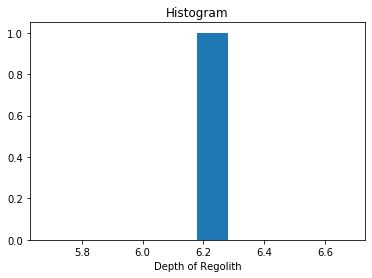

In [32]:
xds['der'].sel({'measures': 'der'}).plot()

### CSV Results

In [33]:
import pandas as pd

with ZipFile(filepath) as z:
    with z.open('result.csv') as zf:
        df = pd.read_csv(zf)
df.head()

,measures,lat,lon,der,des,ece
0,der,-27.78375,153.26375,6.1803,NaN,NaN
1,des,-27.78375,153.26375,NaN,1.1515,NaN
2,ece,-27.78375,153.26375,NaN,NaN,9.741


## Hand-drawn Polygon Selection

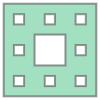

In [34]:
from shapely import wkt

with open("data/polygons/rect_holes.wkt", "r") as f:
    rect_holes_geom = wkt.loads(f.read())
rect_holes_geom 

In [35]:
rect_holes_geom.wkt[:500]

'POLYGON ((150.005 -29.005, 150.005 -27.005, 152.005 -27.005, 152.005 -29.005, 150.005 -29.005), (150.6716666666667 -28.33833333333333, 151.3383333333333 -28.33833333333333, 151.3383333333333 -27.67166666666667, 150.6716666666667 -27.67166666666667, 150.6716666666667 -28.33833333333333), (150.225 -28.785, 150.445 -28.785, 150.445 -28.565, 150.225 -28.565, 150.225 -28.785), (150.8916666666667 -28.785, 151.1116666666667 -28.785, 151.1116666666667 -28.565, 150.8916666666667 -28.565, 150.891666666666'

In [36]:
processid = 'one_wps_process'
inputs = [
    ("variables", "nto, phc, pto"),
    ("spatial_selection_type", "polygon"),
    ("geometry", rect_holes_geom.wkt)
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

'ProcessAccepted'

In [37]:
monitor_execution(execution, sleepSecs=10, download=True, filepath='data/outputs/out20201014T1517.zip')

Execution status: PyWPS Process started
Execution status: rectangular_region select 8/12 (66%)
Execution status: PyWPS Process Soil & Land form (soillandform) combined process for spatial and multiple-variable selections. finished


In [38]:
filepath='data/outputs/out20201014T1517.zip'

### Zip Results

In [39]:
from zipfile import ZipFile

f = ZipFile(filepath)
print(f.namelist())
f.close()

['nto.tif', 'nto.csv', 'pto.tif', 'result.zarr', 'metadata.json', 'pto.csv', 'result.csv', 'phc.csv', 'phc.tif', 'result.nc']


### NetCDF Results

In [40]:
import xarray as xr

with ZipFile(filepath) as z:
    res = z.extract('result.nc', path='workspace/data/outputs/')
    xds = xr.load_dataset(res)
xds

<xarray.Dataset>
Dimensions:      (lat: 796, lon: 796)
Coordinates:
  * lat          (lat) float64 -29.0 -29.0 -29.0 -29.0 ... -27.01 -27.01 -27.01
  * lon          (lon) float64 150.0 150.0 150.0 150.0 ... 152.0 152.0 152.0
    spatial_ref  int32 0
Data variables:
    nto          (lat, lon) float32 0.062 0.0649 0.0654 ... 0.0731 0.0674 0.0711
    phc          (lat, lon) float32 7.5061 7.3316 6.9871 ... 5.1715 5.2473
    pto          (lat, lon) float32 0.0299 0.0304 0.0321 ... 0.0281 0.026 0.0285
Attributes:
    geospatial_lat_min:         -29.004
    geospatial_lat_max:         -27.006
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_min:         150.006
    geospatial_lon_max:         152.004
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    DOI:                        to be added
    license_data_access:        These data can be freely downloaded and used
    keywords:                   EARTH S

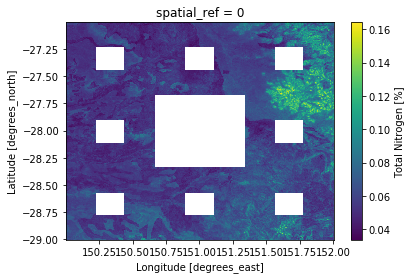

In [41]:
xds['nto'].plot()

## Predefined Region Selection

In [42]:
processid = 'one_wps_process'
inputs = [
    ("variables", "slt, snd, soc"),
    ("spatial_selection_type", "predefined_region"),
    ("gdb_name", "ibra7_subregions_states"), 
    ("rec_id", "347_QLD")
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

'ProcessAccepted'

In [43]:
monitor_execution(execution, sleepSecs=15, download=True, filepath='data/outputs/out20201014T1521.zip')

Execution status: PyWPS Process started
Execution status: rectangular_region select 6/6 (100%)
Execution status: PyWPS Process Soil & Land form (soillandform) combined process for spatial and multiple-variable selections. finished


In [44]:
filepath='data/outputs/out20201014T1521.zip'

### Zip Results

In [45]:
from zipfile import ZipFile
f = ZipFile(filepath)
print(f.namelist())
f.close()

['snd.csv', 'result.zarr', 'metadata.json', 'snd.tif', 'soc.csv', 'slt.tif', 'slt.csv', 'result.csv', 'result.nc', 'soc.tif']


## NetCDF Result

In [46]:
import xarray as xr

with ZipFile(filepath) as z:
    res = z.extract('result.nc', path='workspace/data/outputs/')
    xds = xr.load_dataset(res)
xds

<xarray.Dataset>
Dimensions:      (lat: 735, lon: 294)
Coordinates:
  * lat          (lat) float64 -28.18 -28.17 -28.17 ... -26.34 -26.33 -26.33
  * lon          (lon) float64 152.8 152.8 152.8 152.8 ... 153.5 153.5 153.6
    spatial_ref  int32 0
Data variables:
    slt          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    snd          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    soc          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    geospatial_lat_min:         -28.176
    geospatial_lat_max:         -26.331
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_min:         152.819
    geospatial_lon_max:         153.551
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    DOI:                        to be added
    license_data_access:        These data can be freely downloaded and used
    keywords:                   EARTH S

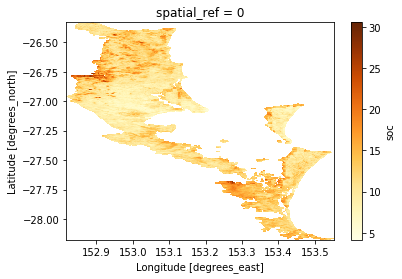

In [48]:
(xds['soc'] * 10).plot(cmap='YlOrBr')


### Metadata

In [47]:
import json

with ZipFile(filepath) as z:
    with z.open('metadata.json') as zf:
        data = json.load(zf)
        print(json.dumps(data, indent=4))


{
    "variables": {
        "codes": [
            "slt",
            "snd",
            "soc"
        ],
        "selected": {
            "slt": "Silt",
            "snd": "Sand",
            "soc": "Organic Carbon"
        }
    },
    "spatial_selection_type": "predefined_region",
    "bounds": {
        "lat_min": -28.17702000000003,
        "lat_max": -26.33033062499999,
        "lon_min": 152.81753281,
        "lon_max": 153.55292
    },
    "predefined_region": {
        "rec_id": "347_QLD",
        "sta_code": "QLD",
        "reg_code": "SEQ",
        "reg_name": "South Eastern Queensland",
        "sub_code": "SEQ04",
        "sub_name": "Sunshine Coast-Gold Coast Lowlands",
        "gdb_name": "ibra7_subregions_states"
    }
}


### Tiff Results

In [49]:
import rasterio as rio

with ZipFile(filepath) as z:
    tf = z.extract('snd.tif', path='data/outputs')
    rds = rio.open(tf)
        
data = {  # gather all the attrs together
    'meta': rds.meta,
    'bounds': rds.bounds,
    'resolution': rds.res,
    'tags': rds.tags, 
    'indexes': rds.indexes,
    'name': rds.name, 
    'mode': rds.mode
}
data  # notice count: 1, means 1 layer

{'meta': {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': None,
  'width': 294,
  'height': 735,
  'count': 1,
  'crs': CRS.from_dict(init='epsg:4326'),
  'transform': Affine(0.002499999999999957, 0.0, 152.8175,
         0.0, 0.0025136239782016334, -28.1775068119891)},
 'bounds': BoundingBox(left=152.8175, bottom=-26.3299931880109, right=153.55249999999998, top=-28.1775068119891),
 'resolution': (0.002499999999999957, -0.0025136239782016334),
 'tags': <function DatasetReader.tags>,
 'indexes': (1,),
 'name': 'data/outputs/snd.tif',
 'mode': 'r'}

In [50]:
rds.read(1)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

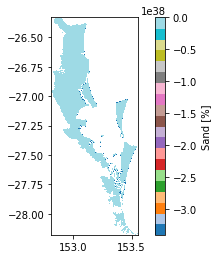

In [54]:
from matplotlib import pyplot as plt

axs = plt.imshow(rds.read(1), cmap='tab20', origin='lower',
                 extent=(rds.bounds.left, rds.bounds.right, rds.bounds.top, rds.bounds.bottom))
plt.colorbar(label='Sand [%]')
plt.show()

### CSV Results

In [55]:
import pandas as pd

with ZipFile(filepath) as z:
    with z.open('result.csv') as zf:
        df = pd.read_csv(zf)
df.head()

,lat,lon,spatial_ref,slt,snd,soc
0,-28.17625,152.81875,0,NaN,NaN,NaN
1,-28.17625,152.82125,0,NaN,NaN,NaN
2,-28.17625,152.82375,0,NaN,NaN,NaN
3,-28.17625,152.82625,0,NaN,NaN,NaN
4,-28.17625,152.82875,0,NaN,NaN,NaN
